# Consumption Responses

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot')

import os; home = os.path.expanduser('~')

processed = home + '/Dropbox/data/mexico_enigh/processed2'
os.chdir(processed)
df = pd.read_csv('data.csv')

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20399 entries, 0 to 20398
Data columns (total 37 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   consumption_transportation  20399 non-null  float64
 1   income_salary               20399 non-null  float64
 2   income_total                20399 non-null  float64
 3   location_size               20399 non-null  int64  
 4   hhid                        20399 non-null  int64  
 5   consumption_food            20399 non-null  float64
 6   consumption_clothing        20399 non-null  float64
 7   consumption_total           20399 non-null  float64
 8   weight                      20399 non-null  float64
 9   income_rental               20399 non-null  float64
 10  location                    20399 non-null  object 
 11  income_transfers            20399 non-null  float64
 12  income_current              20399 non-null  float64
 13  financial_expenditures      203

In [3]:
df['post'] = df['Y'] == 1996

# Income Deciles
1. This section computes the income decile within each year

In [4]:
import statsmodels.stats.weightstats as ws
def get_deciles(x, weights=None):
    stats = ws.DescrStatsW(x, weights=weights)

    deciles =  np.arange(0.1, 1.1, .1)
    income_deciles = stats.quantile(deciles).values
    x_deciles = np.array([np.argmax(income_deciles > xi) for xi in x])
    return x_deciles + 1

print(len(df))
deciles = []
for Y in np.sort(df.Y.unique()):
    data = df.query('Y == @Y')[['hhid', 'income', 'weight']]
    data['decile'] = get_deciles(data['income'], data['weight'])
    data['Y'] = Y
    deciles.append(data)
deciles = pd.concat(deciles)
df = df.merge(deciles[['hhid', 'Y', 'decile']], on=['hhid', 'Y'], how='outer')

20399


# Dummy Variables
1. This section creates dummy variables for sex, education, location, and income decile

In [5]:
dummies ={}
dummies_names = []

to_dummies = ['sex', 'education', 'location_size', 'decile']

for var in to_dummies:
    print('Making dummies for', var)
    # create dummies
    dummies[var] = pd.get_dummies(df[var], drop_first=True, prefix=var)

    # store dummy names to access for regression
    dummies_names += list(dummies[var].columns)


Making dummies for sex
Making dummies for education
Making dummies for location_size
Making dummies for decile


In [6]:
# concatenate dummy values to main dataframe
for data in dummies.values():
    df = pd.concat([df, data], axis=1)

# Interaction Dummy Variables
1. This section creates interactions with the recession and education, sex, and income decile

In [7]:
df['post_education'] = df['post'] * (pd.Categorical(df.education).codes + 1)
C_post_education = pd.get_dummies(df['post_education'], prefix='post_education', drop_first=True)
C_post_education = C_post_education.drop(columns='post_education_1')
dummies_names += list(C_post_education.columns)
df = pd.concat([df, C_post_education], axis=1)

In [8]:
df['post_sex'] = df['post'] * (pd.Categorical(df.sex).codes + 1)
C_post_sex = pd.get_dummies(df['post_sex'], prefix='post_sex', drop_first=True)
C_post_sex = C_post_sex.drop(columns='post_sex_1')
dummies_names += list(C_post_sex.columns)
df = pd.concat([df, C_post_sex], axis=1)

In [9]:
df['post_decile'] = df['post'] * df['decile']
C_post_decile = pd.get_dummies(df['post_decile'], prefix='post_decile')
C_post_decile = C_post_decile.drop(columns=['post_decile_0'])
dummies_names += list(C_post_decile.columns)
df = pd.concat([df, C_post_decile], axis=1)

In [10]:
continuous = ['age', 'age_sq']
X_col = continuous + dummies_names
X = df[X_col]
Y = df[['log_income']]

In [11]:
from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X, Y, sample_weight=df['weight'])
linear.coef_

array([[-4.99160055e-03,  7.17655424e-05, -7.85159247e-03,
        -8.32041177e-02, -8.10099906e-02, -1.28865272e-02,
        -1.58235574e-02, -5.09850737e-02,  7.52258490e-01,
         1.09089859e+00,  1.35410304e+00,  1.58939646e+00,
         1.82503878e+00,  2.08295193e+00,  2.38325085e+00,
         2.80160584e+00,  3.60413710e+00,  1.02118429e-02,
         1.26393895e-02, -5.61039580e-03, -2.18736089e-01,
        -2.33654812e-01, -2.42653612e-01, -2.39890215e-01,
        -2.50747840e-01, -2.60335244e-01, -2.77793256e-01,
        -2.99928981e-01, -3.31787695e-01, -3.54679459e-01]])

In [12]:
nboot = 200
coef_income = np.ones((nboot, 10), dtype=np.float64)
coef_consumption = np.ones((nboot, 10), dtype=np.float64)

In [13]:
def bootstrap_regression(df, X_col, Y_col, income_measure=None, weight='weight', nboot=50):

    coef_consumption = np.ones((nboot, 10), dtype=np.float64)

    if income_measure is not None:
        coef_income = np.ones((nboot, 10), dtype=np.float64)
    else:
        coef_income = None

    for boot in np.arange(nboot):
        df_boot = df.sample(len(df), replace=True, weights=df[weight], axis=0)

        X = df_boot[X_col]
        Y = df_boot[Y_col]

        linear.fit(X, Y)
        coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

        if income_measure is not None:
            Y_income = df_boot[income_measure]

            linear.fit(X, Y_income)
            coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]
    return coef_consumption, coef_income

In [14]:
coef_consumption, coef_income = bootstrap_regression(df, X_col, 'log_consumption', income_measure='log_income')

In [15]:
consumption_types = ['consumption_current',
                     'consumption_food',
                     'consumption_clothing',
                     'consumption_personal',
                     'consumption_health',
                     'consumption_house',
                     'consumption_transportation'
                     ]

In [16]:
dconsumption = {}
dincome = {}
elasticities = {}

for consumption_type in consumption_types:

    dconsumption[consumption_type] = {}
    dincome[consumption_type] = {}
    elasticities[consumption_type] = {}

    df['log_' + consumption_type] = np.log(df[consumption_type])
    dfin = df[df[consumption_type] > 0]
    coef_consumption, coef_income = bootstrap_regression(dfin, X_col, 'log_'+consumption_type, income_measure='log_income')
    elasticity = coef_consumption / coef_income

    dconsumption[consumption_type]['mean'] = np.mean(coef_consumption, axis=0)
    dincome[consumption_type]['mean'] = np.mean(coef_income, axis=0)
    elasticities[consumption_type]['mean'] = np.mean(elasticity, axis=0)

    dconsumption[consumption_type]['q90'] = np.quantile(coef_consumption, 0.90, axis=0)
    dincome[consumption_type]['q90'] = np.quantile(coef_income, 0.90, axis=0)
    elasticities[consumption_type]['q90'] = np.quantile(elasticity, 0.90, axis=0)

    dconsumption[consumption_type]['q10'] = np.quantile(coef_consumption, 0.10, axis=0)
    dincome[consumption_type]['q10'] = np.quantile(coef_income, 0.10, axis=0)
    elasticities[consumption_type]['q10'] = np.quantile(elasticity, 0.10, axis=0)

/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/mitch/envs/main/lib/python3.9/site-packages/pandas/core/arraylike.py:396:

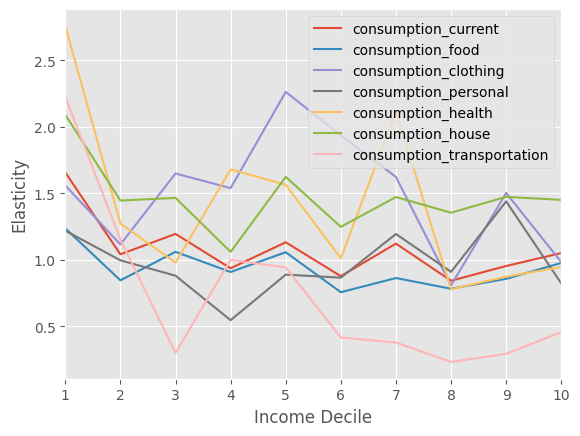

In [21]:
deciles = np.arange(1, 11)
plt.clf()
for consumption_type in consumption_types:
    plt.plot(deciles, elasticities[consumption_type]['mean'], label=consumption_type)

plt.ylabel('Elasticity')
plt.xlabel('Income Decile')
plt.margins(x=0)
plt.legend();

In [23]:
coef_consumption = np.ones((nboot, 10), dtype=np.float64)
coef_income = np.ones((nboot, 10), dtype=np.float64)

In [24]:
for boot in np.arange(nboot):
    df_boot = df.sample(len(df), replace=True, weights=df['weight'], axis=0)
    X = df_boot[X_col]
    Y_income = df_boot[['log_income']]
    Y_consumption = df_boot[['log_consumption']]

    linear.fit(X, Y_income)
    coef_income[boot, :] = np.squeeze(linear.coef_)[-10:]

    linear.fit(X, Y_consumption)
    coef_consumption[boot, :] = np.squeeze(linear.coef_)[-10:]

In [25]:
coef_elasticity = coef_consumption / coef_income

In [26]:
coef_income_q10 = np.quantile(coef_income, q=0.10, axis=0)
coef_income_q90 = np.quantile(coef_income, q=0.90, axis=0)
coef_income_mean = np.mean(coef_income, axis=0)

coef_consumption_q10 = np.quantile(coef_consumption, q=0.10, axis=0)
coef_consumption_q90 = np.quantile(coef_consumption, q=0.90, axis=0)
coef_consumption_mean = np.mean(coef_consumption, axis=0)

coef_elasticity_q10 = np.quantile(coef_elasticity, q=0.10, axis=0)
coef_elasticity_q90 = np.quantile(coef_elasticity, q=0.90, axis=0)
coef_elasticity_mean = np.mean(coef_elasticity, axis=0)

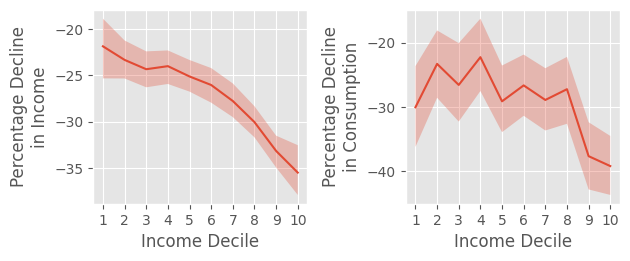

In [29]:
deciles = np.arange(1, 11)

plt.subplot(221)
plt.plot(deciles, 100*coef_income_mean)
plt.fill_between(deciles, 100*coef_income_q10, 100*coef_income_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Income')

plt.subplot(222)
plt.plot(deciles, 100*coef_consumption_mean)
plt.fill_between(deciles, 100*coef_consumption_q10, 100*coef_consumption_q90, alpha=0.3)
plt.xticks(deciles)
plt.xlabel('Income Decile')
plt.ylabel('Percentage Decline\nin Consumption')

plt.tight_layout()

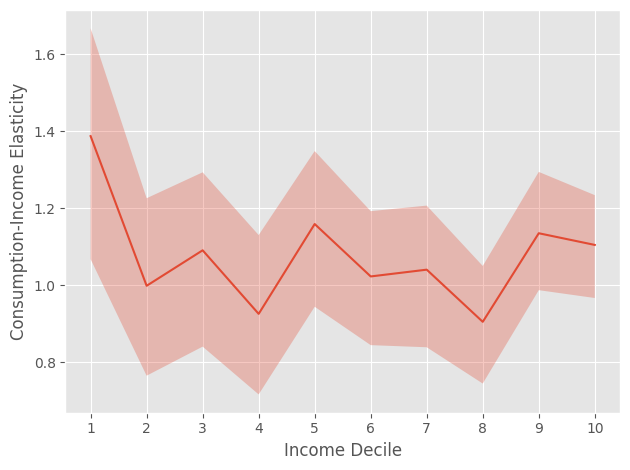

In [30]:
plt.plot(deciles, coef_elasticity_mean)
plt.fill_between(deciles, coef_elasticity_q10, coef_elasticity_q90, alpha=0.3)
plt.ylabel('Consumption-Income Elasticity')

plt.xticks(deciles)
plt.xlabel('Income Decile')

plt.tight_layout()